In [10]:
# ## Create a netcdf file with a matrix of processed time series
# this works with environment npl2025b
# to run on the command line:
#
# module load conda
# conda activate npl-2025b
# python create_metrics_matrix.py


# This is a script version of a python notebook


import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr


import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import glob


import nc_time_axis
import cartopy.crs as ccrs
import cartopy


import warnings
#warnings.filterwarnings("ignore", message="invalid value encountered in divide")

import pickle

# --- custom files
# load custom functions for analyzing flat10

from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 


# ###-------------####
# define which runs and models

outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1','K','kg m-2 s-1']


# global and three latitude bands: trop, mid, high
latlist=['global','highlat','troplat','midlat']
troplat=30
highlat=60

## unit conversions
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

# initialize a dictionary to hold all of the data
data_dict={}


# ###---------------####

#-- load grid info
data_dict = load_grid(data_dict,modellist)


#-- load data
#data_dict=load_flat10(data_dict, modellist, runlist, runlist_wc, varlist)

#-- toggle to analysis lists
modellist=modellist_orig
varlist=['cLitter']
modellist=['HadCM3LC-Bris']

# ###---------------####
# create matrix of zonal mean time series for 

#- initialize
C_global_mat= np.full([350,len(modellist),len(runlist),len(varlist)],np.nan)
C_highlat_mat= np.full([350,len(modellist),len(runlist),len(varlist)],np.nan)
C_troplat_mat= np.full([350,len(modellist),len(runlist),len(varlist)],np.nan)
C_midlat_mat= np.full([350,len(modellist),len(runlist),len(varlist)],np.nan)

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('processing model: ' +model)

    # get area and landfrac from the dictionary where they have been pre-loaded
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('processing run: ' +run)

        #ds=load_one_model(model,runlist_wc[e],varlist)
        #ds=data_dict[modellist[m] +'_' +runlist[e]]


        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            print('processing variable: ' +var)

            ds=None
            ds=load_one_model_onevar(model,runlist_wc[e],var)
            
            if ds is not None: # catch the case when the variable doesn't exist
                    
    
                if model=='CESM2':
                    area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
                else:
                    area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
                
                landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
                
                if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
                    landfrac=landfrac/100
                    
                landarea=area*landfrac
                 
    
                # NorESM has drift that needs to be corrected
                # load the drift correction matrix and remove the drift
                if model=='NorESM2-LM':
                    if var=='cVeg':
                        field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTVEGC_ann_drift.pkl','rb'))
                        adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                        ty=ds['time'].dt.year
                        tyindx=ty-ty[0]+1
                        adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1
    
                        ds[var]=ds[var]+adjustment # remove the drift from the variable
                        
                    elif var=='cSoil':
                        field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTSOMC_ann_drift.pkl','rb'))
                        adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                        ty=ds['time'].dt.year
                        tyindx=ty-ty[0]+1
                        adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1
    
                        ds[var]=ds[var]+adjustment # remove the drift from the variable
                        
                    elif var=='cLitter':
                        field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTLITC_ann_drift.pkl','rb'))
                        adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                        ty=ds['time'].dt.year
                        tyindx=ty-ty[0]+1
                        adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1
    
                        ds[var]=ds[var]+adjustment # remove the drift from the variable
    
                data_var= weighted_temporal_mean(ds, var)
    
                # mask for nans 
                # Mask landarea where it's zero or NaN to avoid invalid values
                valid_mask = (landarea > 0) & landarea.notnull()
                masked_landarea = landarea.where(valid_mask)
                masked_data = data_var.where(valid_mask)
    
                landarea_global = masked_landarea.sum(dim=['lat','lon'])
                landarea_highlat = ((masked_landarea.where(ds.lat>=highlat)).sum(dim=['lat','lon']))
                landarea_troplat = ((masked_landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))
                landarea_midlat = ((masked_landarea.where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))
    
                if var=='tas' or var=='pr': 
                    C_global =(((masked_data*masked_landarea)).sum(dim=['lat','lon']))/landarea_global
                    C_highlat=(((masked_data*masked_landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon']))/landarea_highlat
                    C_troplat=(((masked_data*masked_landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))/landarea_troplat
                    C_midlat=(((masked_data*masked_landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))/landarea_midlat
        
                    #put into matrix 
                    C_global_mat[0:len(C_global),m,e,v]= C_global
                    C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
                    C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
                    C_midlat_mat[0:len(C_global),m,e,v]= C_midlat
                
                else: # it is a carbon variable and we want to make a sum
                    # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
                    # our area variable is in m2
                    C_global =(((masked_data*masked_landarea)).sum(dim=['lat','lon']))
                    C_highlat=((masked_data*masked_landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
                    C_troplat=((masked_data*masked_landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
                    C_midlat=((masked_data*masked_landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
        
                    #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
                    C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
                    C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
                    C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
                    C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg
    
                # reset values after the end of the time series to nan
                C_global_mat[(len(C_global)):,m,e,v]=np.nan
                C_highlat_mat[(len(C_highlat)):,m,e,v]=np.nan
                C_troplat_mat[(len(C_troplat)):,m,e,v]=np.nan
                C_midlat_mat[(len(C_midlat)):,m,e,v]=np.nan

                del ds # remove the dataset from memory
                del data_var # remove from memory
                del masked_data

# ###----------------####

# put the matrix into an xarray dataset
data_array_combined = np.full((len(ts), len(modellist), len(runlist), len(varlist), len(latlist)),np.nan)

data_array_combined[:,:,:,:,0]=C_global_mat
data_array_combined[:,:,:,:,1]=C_highlat_mat
data_array_combined[:,:,:,:,2]=C_troplat_mat
data_array_combined[:,:,:,:,3]=C_midlat_mat


# ###----------------####
# put into an xarray dataset

ds_C_global= xr.Dataset(
    {
        "data": (["time", "model", "run", "var","latrange"], data_array_combined)
    },
    coords={
        "time": ts,
        "model": modellist,
        "run": runlist,
        "var": varlist,
        "latrange": latlist
    }
)


# ###----------------####

# - save the matrix to a netcdf file
#ds_C_global.to_netcdf("C_metrics_matrix.nc")
print('Done!')

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info
processing model: HadCM3LC-Bris
processing run: flat10
processing variable: cLitter
loading variable: cLitter
no data for cLitter
processing run: flat10_zec
processing variable: cLitter
loading variable: cLitter
no data for cLitter
processing run: flat10_cdr
processing variable: cLitter
loading variable: cLitter
no data for cLitter
Done!


In [11]:
C_midlat_mat

array([[[[nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan]]],


       ...,


       [[[nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan]]]])

(350, 1, 3, 1)


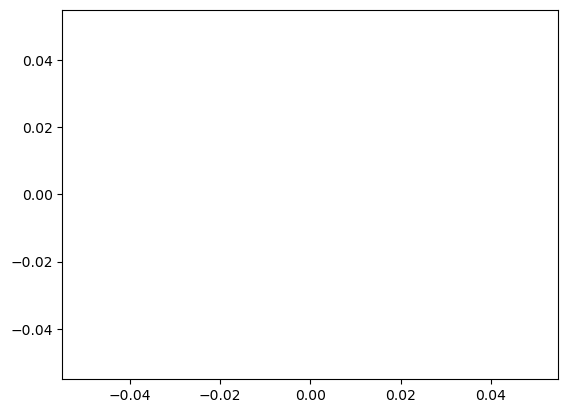

In [12]:
print(np.shape(C_midlat_mat))


import matplotlib
plt.plot(C_midlat_mat[:,:,1,0])


#plt.plot(C_midlat)

In [3]:
# ## Create a netcdf file with a matrix of processed time series
# this works with environment npl2025b
# to run on the command line:
#
# module load conda
# conda activate npl-2025b
# python create_metrics_matrix.py


# This is a script version of a python notebook


import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr


import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import glob


import nc_time_axis
import cartopy.crs as ccrs
import cartopy


import warnings
#warnings.filterwarnings("ignore", message="invalid value encountered in divide")

# --- custom files
# load custom functions for analyzing flat10

from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 


# ###-------------####
# define which runs and models

outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1','K','kg m-2 s-1']


# global and three latitude bands: trop, mid, high
latlist=['global','highlat','troplat','midlat']
troplat=30
highlat=60

## unit conversions
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

# initialize a dictionary to hold all of the data
data_dict={}


# ###---------------####

#-- load grid info
data_dict = load_grid(data_dict,modellist)


#-- load data
#data_dict=load_flat10(data_dict, modellist, runlist, runlist_wc, varlist)

#-- toggle to analysis lists
modellist=modellist_orig
varlist=varlist_load


# ###---------------####
# create matrix of zonal mean time series for 

#- initialize
C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('processing model: ' +model)

    # get area and landfrac from the dictionary where they have been pre-loaded
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('processing run: ' +run)

        #ds=load_one_model(model,runlist_wc[e],varlist)
        #ds=data_dict[modellist[m] +'_' +runlist[e]]


        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            print('processing variable: ' +var)

            ds=load_one_model_onevar(model,runlist_wc[e],var)


            if model=='CESM2':
                area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
            else:
                area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
            
            landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
            
            if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
                landfrac=landfrac/100
                
            landarea=area*landfrac
             

            # NorESM has drift that needs to be corrected
            # load the drift correction matrix and remove the drift
            if model=='NorESM2-LM':
                if var=='cVeg':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTVEGC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    tyindx=ty-ty[0]+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]+adjustment # remove the drift from the variable
                    
                elif var=='cSoil':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTSOMC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    tyindx=ty-ty[0]+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]+adjustment # remove the drift from the variable
                    
                elif var=='cLitter':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTLITC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    tyindx=ty-ty[0]+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]+adjustment # remove the drift from the variable

            data_var= weighted_temporal_mean(ds, var)

            # mask for nans 
            # Mask landarea where it's zero or NaN to avoid invalid values
            valid_mask = (landarea > 0) & landarea.notnull()
            masked_landarea = landarea.where(valid_mask)
            masked_data = data_var.where(valid_mask)

            landarea_global = masked_landarea.sum(dim=['lat','lon'])
            landarea_highlat = ((masked_landarea.where(ds.lat>=highlat)).sum(dim=['lat','lon']))
            landarea_troplat = ((masked_landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))
            landarea_midlat = ((masked_landarea.where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))

            if var=='tas' or var=='pr': 
                C_global =(((masked_data*masked_landarea)).sum(dim=['lat','lon']))/landarea_global
                C_highlat=(((masked_data*masked_landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon']))/landarea_highlat
                C_troplat=(((masked_data*masked_landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))/landarea_troplat
                C_midlat=(((masked_data*masked_landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))/landarea_midlat
    
                #put into matrix 
                C_global_mat[0:len(C_global),m,e,v]= C_global
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat
            
            else: # it is a carbon variable and we want to make a sum
                # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
                # our area variable is in m2
                C_global =(((masked_data*masked_landarea)).sum(dim=['lat','lon']))
                C_highlat=((masked_data*masked_landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
                C_troplat=((masked_data*masked_landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
                C_midlat=((masked_data*masked_landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
                #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
                C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg

            # reset values after the end of the time series to nan
            C_global_mat[(len(C_global)):,m,e,v]=np.nan
            C_highlat_mat[(len(C_highlat)):,m,e,v]=np.nan
            C_troplat_mat[(len(C_troplat)):,m,e,v]=np.nan
            C_midlat_mat[(len(C_midlat)):,m,e,v]=np.nan

        del ds # remove the dataset from memory
        del data_var # remove from memory
        del masked_data

# ###----------------####

# put the matrix into an xarray dataset
data_array_combined = np.full((len(ts), len(modellist), len(runlist), len(varlist), len(latlist)),np.nan)

data_array_combined[:,:,:,:,0]=C_global_mat
data_array_combined[:,:,:,:,1]=C_highlat_mat
data_array_combined[:,:,:,:,2]=C_troplat_mat
data_array_combined[:,:,:,:,3]=C_midlat_mat


# ###----------------####
# put into an xarray dataset

ds_C_global= xr.Dataset(
    {
        "data": (["time", "model", "run", "var","latrange"], data_array_combined)
    },
    coords={
        "time": ts,
        "model": modellist,
        "run": runlist,
        "var": varlist,
        "latrange": latlist
    }
)


# ###----------------####

# - save the matrix to a netcdf file
ds_C_global.to_netcdf("C_metrics_matrix.nc")


ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info
processing model: ACCESS-ESM1-5
processing run: flat10
processing variable: cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *lat10 cVeg


KeyboardInterrupt: 